# 1. Importing Libraries

In [302]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

# PlottingNet 
sns.set()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 2. Importing Data

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/ALDA/data.csv')

# 3. Exploratory Data Analysis and Data Preparation

## 3.1 Preview of the raw data

In [303]:
df_raw

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,2.394682e-02,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,2.550000e+07,0.458521,7.900790e-04,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0

## 3.2 Missing values

In [ ]:
df_raw.isna().values.any()

False

This shows that there are **no missing values** in the dataset.

## 3.3 Dividing the feature set from label set

In [ ]:
df_X_raw = df_raw.iloc[:, 1:]
df_y_raw = df_raw.iloc[:, 0]

print(f'Shape of the feature set:', df_X_raw.shape)
print(f'Shape of the label set:', df_y_raw.shape)

Shape of the feature set: (6819, 95)
Shape of the label set: (6819,)


## 3.4 Divide the raw dataset into bankrupt and non-bankrupt companies (1 = banktupt, 0 = non-bankrupt)

In [ ]:
df_non_bankrupt = df_raw[df_raw['Bankrupt?'] == 0]
df_bankrupt = df_raw[df_raw['Bankrupt?'] == 1]

print(f'Shape of the non-bankrupt set:', df_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_bankrupt.shape)

Shape of the non-bankrupt set: (6599, 96)
Shape of the bankrupt set: (220, 96)


## 3.5 Plot the label data (check for imbalance)

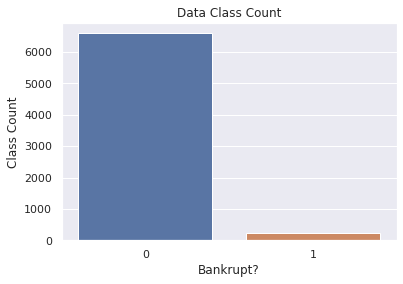

In [ ]:
sns.countplot(x='Bankrupt?', data=df_raw)
plt.title("Data Class Count")
plt.ylabel("Class Count")
plt.show()

This plot shows the imbalance of the data; there is ratio 30:1 for non-bankrupt and bankrupt companies.

## 3.6 Variance

### 3.6.1 Extracting standard deviations of the features

In [ ]:
stds = df_X_raw.std(axis = 0)
stds = stds.sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot([*range(95)], stds.values)
plt.title('The amount of variance in the features', fontsize=20, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Standard deviations')
plt.xticks(range(0, 95, 2))
plt.show()

The tail becomes unreadable because of the magnitude of y-axis. Therefore, we plot the tail (24:) in the next figure.

In [ ]:
plt.figure(figsize=(20,6))
plt.plot([*range(24,95)], stds.values[24:])
plt.title('The amount of variance in the features', fontsize=20, fontweight='bold')
plt.xlabel('Feature')
plt.ylabel('Variance [standard deviation]')
plt.xticks(range(24, 95, 2))
plt.show()

In [ ]:
stds

 Quick Asset Turnover Rate               3.374944e+09
 Inventory Turnover Rate (times)         3.247967e+09
 Operating Expense Rate                  3.237684e+09
 Cash Turnover Rate                      2.938623e+09
 Total Asset Growth Rate                 2.897718e+09
                                             ...     
 Continuous Net Profit Growth Rate       1.006296e-02
 Total Asset Return Growth Rate Ratio    9.634209e-03
 Cash Flow to Sales                      9.341346e-03
 Working capitcal Turnover Rate          8.959384e-03
 Net Income Flag                         0.000000e+00
Length: 95, dtype: float64

There is one feature that has no variance (Net Income Flag). This means that it takes the same value for every datapoint.

### 3.6.2 Getting rid of the features with no variance

In [ ]:
# Creating a copy of the raw dataset
df_X_EDA_var = df_X_raw.copy()

# Removing the useless feature
df_X_EDA_var.drop(' Net Income Flag', axis=1, inplace=True)

print(f'Shape of the new dataset:', df_X_EDA_var.shape)

Shape of the new dataset: (6819, 94)


## 3.7 Scaling

In [ ]:
# Transforming data to have a mean of 0 and std of 1 (99% of values are [-3, 3])
scaler = StandardScaler()
df_X_EDA_scaled = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_scaled.loc[:,:] = scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Scaling all values to [0, 1]
min_max_scaler = MinMaxScaler()
df_X_EDA_minmax = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_minmax.loc[:,:] = min_max_scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Scaling all values to [-1, 1]
max_abs_scaler = MaxAbsScaler()
df_X_EDA_maxabs = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_maxabs.loc[:,:] = max_abs_scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Scaling statistically using the Inter-Quartile Range (using the bulk of the data, so robust to outliers)
robust_scaler = RobustScaler()
df_X_EDA_robust = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_robust.loc[:,:] = robust_scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Appling non-linear transformation to map features to a uniform distribution
uniform_scaler = QuantileTransformer(output_distribution='uniform')
df_X_EDA_uniform = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_uniform.loc[:,:] = uniform_scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Appling non-linear transformation to map features to a Gaussian distribution
gaussian_scaler = QuantileTransformer(output_distribution='normal')
df_X_EDA_gaussian = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_gaussian.loc[:,:] = gaussian_scaler.fit_transform(df_X_EDA_var)

In [ ]:
# Appling power-like transformation to make the data more Gaussian-like
power_scaler = PowerTransformer(method='yeo-johnson')
df_X_EDA_power = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_power.loc[:,:] = power_scaler.fit_transform(df_X_EDA_var)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [ ]:
# Normalizing the samples individually to unit norm. Row-based normalization technique
normalizer = Normalizer()
df_X_EDA_norm = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_norm.loc[:,:] = normalizer.fit_transform(df_X_EDA_var)

## 3.8 Correlation

### 3.8.1 Pairwise correlation between features and labels

In [ ]:
# Correlation between the features and the labels
feat_label_corr = df_X_EDA_scaled.corrwith(df_y_raw)

# Sort descending
feat_label_corr_sorted = feat_label_corr.abs().sort_values(ascending=False)

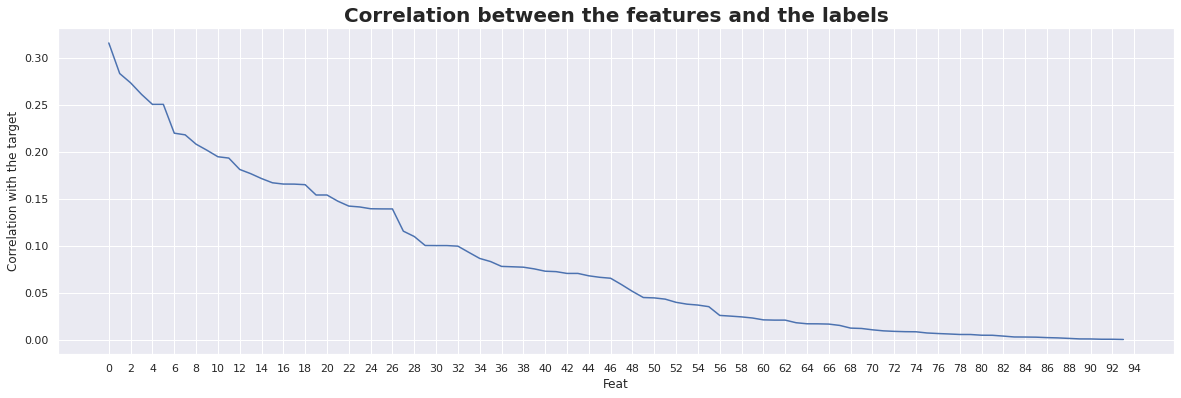

In [ ]:
# Plotting
plt.figure(figsize=(20,6))
plt.plot([*range(94)],feat_label_corr_sorted.values)
plt.title('Correlation between the features and the labels', fontsize=20, fontweight='bold')
plt.xlabel('Feat')
plt.ylabel('Correlation with the target')
plt.xticks(range(0, 95, 2))
plt.show()

The correlation of the features with the ranges from 32% to almost 0%. We decide to set a threshold of **correlation to 1% in order to deem a feature predictive**. Therefore, we drop the features that are correlated with the label in less than 1% (23 features).

In [ ]:
# Sorting the features set with descending correlation with the labels
new_col = feat_label_corr_sorted.index
new_col = new_col.to_numpy()
df_X_EDA_scaled_sorted = df_X_EDA_scaled.reindex(columns=new_col)

### 3.8.2 Dropping features with correlation < 0.1 with the labels

In [ ]:
# Features to drop
feat_to_drop = feat_label_corr_sorted[feat_label_corr_sorted < 0.01].index

# Dropping
df_X_EDA_scaled_sorted_dropped = df_X_EDA_scaled_sorted.drop(feat_to_drop, axis=1)

print(f'Shape of the new dataset:', df_X_EDA_scaled_sorted_dropped.shape)

Shape of the new dataset: (6819, 71)


### 3.8.3 Pairwise correlation between features

In [ ]:
# Plotting
feat_corr_matrix = df_X_EDA_scaled_sorted_dropped.corr()
feat_corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

### 3.8.4 Extracting the highly correlated features

In [ ]:
def correlation(df, threshold):
    ''' A function extracting highly correlated
    features (according to a threshold). '''
    
    correlated_features = []
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i,j]) > threshold:
                feature = correlation_matrix.columns[i]
                if feature not in correlated_features:
                    correlated_features.append(feature)

    return correlated_features

In [ ]:
# A list of highly correlated features (more than 0.9)
corr_features = correlation(df_X_EDA_scaled_sorted_dropped, 0.9)

print('The list of highly correlated features:')

corr_features

The list of highly correlated features:


[' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Liability to Equity',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (C)',
 ' Current Liabilities/Equity',
 ' Current Liability to Equity',
 ' Operating profit/Paid-in capital',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Regular Net Profit Growth Rate',
 ' Current Liabilities/Liability']

### 3.8.5 Dropping the highly correlated features

We want to drop the highly correlated features and **keep the ones (out of each pair) that have higher correlation with labels**.

In [ ]:
# Dropping
df_X_EDA_scaled_sorted_dropped_2 = df_X_EDA_scaled_sorted_dropped.drop(corr_features, axis=1)

print(f'Shape of the new dataset:', df_X_EDA_scaled_sorted_dropped_2.shape)

Shape of the new dataset: (6819, 55)


In [ ]:
# Plotting the correlation matrix
feat_corr_matrix_dropped = df_X_EDA_scaled_sorted_dropped_2.corr()
feat_corr_matrix_dropped.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

## 3.9 Balancing the Dataset

We decided to tackle the imbalance of the dataset problem by applying SMOTE and stratified sampling.

In [ ]:
# Concatinate feature and label sets
df_scaled_imbalanced = pd.concat([df_y_raw, df_X_EDA_scaled], axis=1)
df_manually_clean = pd.concat([df_y_raw, df_X_manually_clean], axis=1)

# Divide for bankrupt and non-bankrupt sets
df_scaled_non_bankrupt = df_scaled_imbalanced[df_scaled_imbalanced['Bankrupt?'] == 0]
df_scaled_bankrupt = df_scaled_imbalanced[df_scaled_imbalanced['Bankrupt?'] == 1]

df_manually_clean_non_bankrupt = df_manually_clean[df_manually_clean['Bankrupt?'] == 0]
df_manually_clean_bankrupt = df_manually_clean[df_manually_clean['Bankrupt?'] == 1]

print(f'Only standardized data:\nShape of the non-bankrupt set:', df_scaled_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_scaled_bankrupt.shape)

print(f'\nManually cleaned data:\nShape of the non-bankrupt set:', df_manually_clean_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_manually_clean_bankrupt.shape)

Only standardized data:
Shape of the non-bankrupt set: (6599, 95)
Shape of the bankrupt set: (220, 95)

Manually cleaned data:
Shape of the non-bankrupt set: (6599, 56)
Shape of the bankrupt set: (220, 56)


### 3.9.1 Stratified Sampling

We go about stratified sampling technique by simply **multiplying the datapoints of underrepresented class 1** until the number of datapoints matches the number of datapoints in the majority class 0.

In [ ]:
def stratify(df):
    ''' Function upsampling a dataset by
    repeating the same values. It creates 
    a set of 6599 datapoints out of 220. '''

    df_strat = df.copy()
    for i in range(28):
        df_strat = pd.concat([df_strat, df], ignore_index=True)

    # Add 219 first datasets to match the non-bankrupt count
    df_strat = pd.concat([df_strat, df[:-1]], ignore_index=True)

    return df_strat

In [ ]:
def strat_upsample(df_X, df_y):
    '''Takes in a dataframe and upsamples the minority class until class sizes are equal'''
    df = df = pd.concat([df_y, df_X], axis=1)

    df_non_bankrupt = df[df['Bankrupt?'] == 0]
    df_bankrupt = df[df['Bankrupt?'] == 1]

    quot = df_non_bankrupt.shape[0]//df_bankrupt.shape[0]
    assert quot > 1
    rem = df_non_bankrupt.shape[0] - (df_bankrupt.shape[0] * quot)

    df_strat = df_bankrupt.copy()
    for i in range(quot-1):
        df_strat = pd.concat([df_strat, df_bankrupt], ignore_index=True)

    # Add rem first datasets to match the non-bankrupt count
    df_strat = pd.concat([df_strat, df_bankrupt[:rem]], ignore_index=True)
    assert df_strat.shape == df_non_bankrupt.shape

    # Combining the classes
    df_stratified = pd.concat([df_non_bankrupt, df_strat], ignore_index=True)

    # Split by x and y again
    df_X_strat = df_stratified.iloc[:,1:]
    df_y_strat = df_stratified.iloc[:,0]
    return (df_X_strat, df_y_strat)

In [ ]:
# Stratify the sets
df_scaled_bankrupt_strat = stratify(df_scaled_bankrupt)
df_manually_clean_bankrupt_strat = stratify(df_manually_clean_bankrupt)

# Combining the classes
df_stratified_scaled = pd.concat([df_scaled_non_bankrupt, df_scaled_bankrupt_strat], ignore_index=True)
df_stratified_manually_cleaned = pd.concat([df_manually_clean_non_bankrupt, df_manually_clean_bankrupt_strat], ignore_index=True)

print(f'The stratified standardized set:', df_stratified_scaled.shape)
print(f'The stratified manually cleaned set:', df_stratified_manually_cleaned.shape)

(ex_X, ex_y) = strat_upsample(df_X_EDA_scaled, df_y_raw)
assert df_stratified_scaled.equals(pd.concat([ex_y, ex_X], axis=1))

The stratified standardized set: (13198, 95)
The stratified manually cleaned set: (13198, 56)


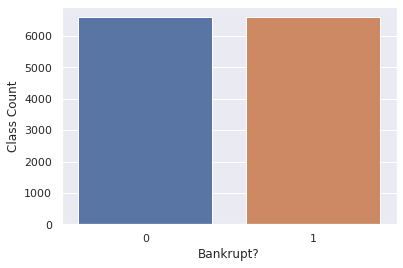

In [ ]:
# Plotting the classes
sns.countplot(x='Bankrupt?', data=df_stratified_scaled)
#plt.title('Upsampled Data Class Counts', fontsize=20, fontweight='bold')
plt.ylabel("Class Count")
plt.show()

#sns.countplot(x='Bankrupt?', data=df_stratified_manually_cleaned)
#plt.title('Manually cleaned data, stratified', fontsize=20, fontweight='bold')
#plt.show()

Classes are perfectly balanced.

### 3.9.2 SMOTE

In [ ]:
smote = SMOTE()
df_X_scaled_smote, df_y_smote = smote.fit_resample(df_X_EDA_scaled, df_y_raw)
df_X_manually_clean_smote, df_y_smote = smote.fit_resample(df_X_manually_clean, df_y_raw)

# smote converts df to nparray, to converting back to df
df_X_scaled_smote = pd.DataFrame(df_X_scaled_smote, columns=df_X_EDA_scaled.columns)
df_y_smote = pd.Series(df_y_smote, name=df_y_raw.name)
df_X_manually_clean_smote = pd.DataFrame(df_X_manually_clean_smote, columns=df_X_manually_clean.columns)
df_y_smote = pd.Series(df_y_smote, name=df_y_raw.name)

df_SMOTE_scaled = pd.concat([df_y_smote, df_X_scaled_smote], axis=1)
df_SMOTE_manually_cleaned = pd.concat([df_y_smote, df_X_manually_clean_smote], axis=1)

print(f'SMOTE-ed standardized set:', df_SMOTE_scaled.shape)
print(f'SMOTE-ed manually cleaned set:', df_SMOTE_manually_cleaned.shape)

SMOTE-ed standardized set: (13198, 95)
SMOTE-ed manually cleaned set: (13198, 56)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


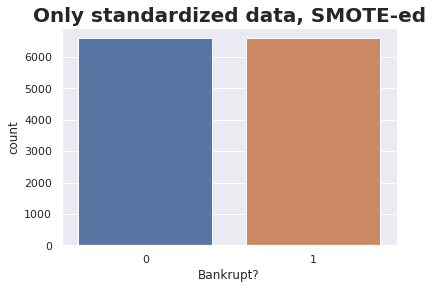

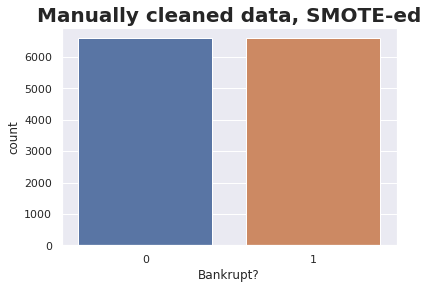

In [ ]:
# Plotting the classes
sns.countplot(x='Bankrupt?', data=df_SMOTE_scaled)
plt.title('Only standardized data, SMOTE-ed', fontsize=20, fontweight='bold')
plt.show()

sns.countplot(x='Bankrupt?', data=df_SMOTE_manually_cleaned)
plt.title('Manually cleaned data, SMOTE-ed', fontsize=20, fontweight='bold')
plt.show()

Classes are perfectly balanced.

## 3.10 PCA

In [290]:
# Applying PCA to data
pca = PCA()
pca.fit(df_X_manually_clean_smote)
df_pca = pca.transform(df_X_manually_clean)   # INPUT DESIRED FEATURE SET HERE!

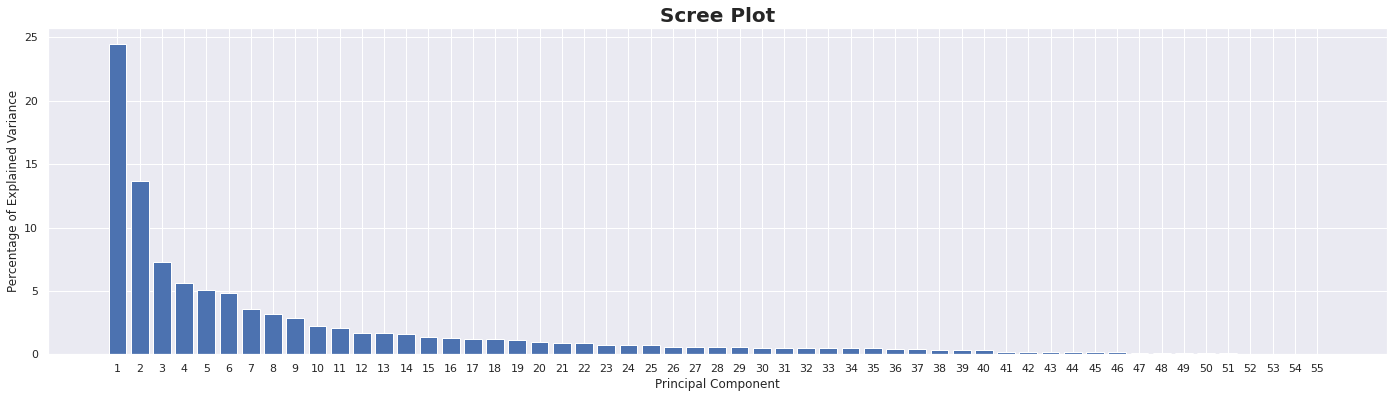

In [291]:
# Scree plot
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(24,6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.title('Scree Plot', fontsize=20, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

## 3.11 Train - val - test split

In [ ]:
# Splitting train:val:test 60:20:20
X_train, X_test, y_train, y_test = train_test_split(df_X_scaled_smote, df_y_smote, test_size=0.2, random_state=0)   # INPUT THE DESIRED FEATURE SET HERE!
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

## 3.10 Permutation Feature Importance

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

results = permutation_importance(rfc, X_val, y_val)
importance = results.importances_mean

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
rfc.score(X_val, y_val)

0.9784090909090909

In [ ]:
df_X_manually_clean_smote[:,7]

TypeError: ignored

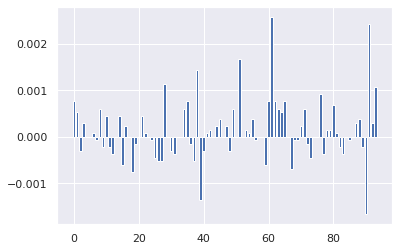

In [ ]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

results = permutation_importance(rfc, X_val, y_val)
importance = results.importances_mean

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00053
Feature: 1, Score: 0.00076
Feature: 2, Score: -0.00045
Feature: 3, Score: -0.00008
Feature: 4, Score: -0.00015
Feature: 5, Score: -0.00045
Feature: 6, Score: -0.00061
Feature: 7, Score: -0.00053
Feature: 8, Score: 0.00159
Feature: 9, Score: -0.00023
Feature: 10, Score: 0.00023
Feature: 11, Score: -0.00053
Feature: 12, Score: -0.00045
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00083
Feature: 15, Score: -0.00098
Feature: 16, Score: 0.00030
Feature: 17, Score: 0.00023
Feature: 18, Score: -0.00098
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00038
Feature: 22, Score: 0.00008
Feature: 23, Score: 0.00008
Feature: 24, Score: -0.00008
Feature: 25, Score: -0.00053
Feature: 26, Score: -0.00091
Feature: 27, Score: -0.00008
Feature: 28, Score: 0.00076
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00015
Feature: 31, Score: -0.00030
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00038
Feature: 35, S

In [ ]:
rfc.score(X_val, y_val)

0.9784090909090909

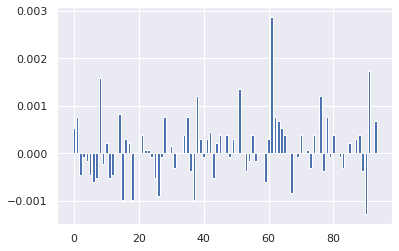

In [ ]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## 3.9 Recursive Feature Elimination

## 3.9.1 Applying RFE using Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfecv = RFECV(rfc, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(df_X_EDA_scaled_sorted, df_y_raw)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=0,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [ ]:
print(f'The optimal number of features:', rfecv.n_features_)

The optimal number of features: 13


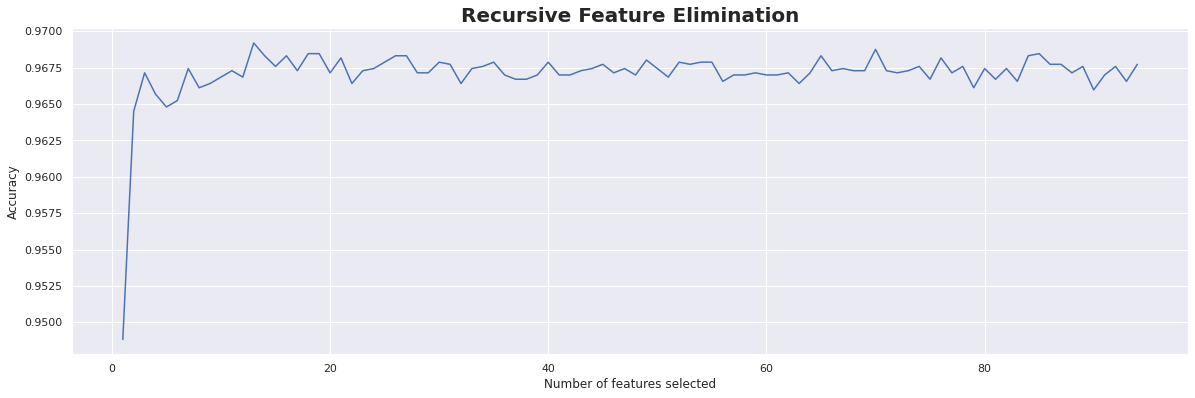

In [ ]:
# Plotting
plt.figure(figsize=(20,6))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('Recursive Feature Elimination', fontsize=20, fontweight='bold')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rfecv.ranking_

array([18, 34, 10,  6,  8,  1,  1, 33,  1,  1, 22, 12,  1,  1, 38, 14,  2,
        1,  9, 26, 29,  4, 49, 30, 78, 48, 32, 36, 66,  1, 21, 28, 41, 13,
       24,  1, 65, 51, 55, 42, 50, 23, 52, 62, 60, 77, 80, 35, 46, 37, 39,
       15, 82, 47, 53, 69, 61, 76, 59, 68, 44, 43, 54, 58, 40, 20,  3, 27,
       70, 64,  1, 16, 19, 25,  1, 11, 81, 63,  1,  7, 72, 75, 73, 17, 71,
        1, 79,  5, 57, 67, 74, 31, 45, 56])

# Different Datasets after Data Preparation

In [ ]:
# Only features with variance = 0 removed: df_X_EDA_var
print(f'Only features with variance = 0 removed:', df_X_EDA_var.shape)

# Features with variance = 0 removed and standardized (z-score): df_X_EDA_scaled
print(f'Features with variance = 0 removed and standardized (z-score):', df_X_EDA_scaled.shape)

# Features with variance = 0 removed, standardized and sorted with descending correlation with the labels: df_X_EDA_scaled_sorted
print(f'Features with variance = 0 removed, standardized and sorted with descending correlation with the labels:', df_X_EDA_scaled_sorted.shape)

# Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed: df_X_EDA_scaled_sorted_dropped
print(f'Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed:', df_X_EDA_scaled_sorted_dropped.shape)

# Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed: df_X_EDA_scaled_sorted_dropped_2
print(f'Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed:', df_X_EDA_scaled_sorted_dropped_2.shape)

# Manually cleaned data (all of the above included): df_X_manually_clean
df_X_manually_clean = df_X_EDA_scaled_sorted_dropped_2.copy()
print(f'Manually cleaned data (all of the above included):', df_X_manually_clean.shape)

Only features with variance = 0 removed: (6819, 94)
Features with variance = 0 removed and standardized (z-score): (6819, 94)
Features with variance = 0 removed, standardized and sorted with descending correlation with the labels: (6819, 94)
Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed: (6819, 71)
Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed: (6819, 55)
Manually cleaned data (all of the above included): (6819, 55)


In [ ]:
# Imbalanced dataset with features with variance = 0 removed and standardized: df_var_imbalanced
print(f'Imbalanced dataset with features with variance = 0 removed and standardized:', df_scaled_imbalanced.shape)

# Imbalanced dataset with manually cleaned data: df_manually_clean
print(f'Imbalanced dataset with manually cleaned data:', df_manually_clean.shape)

# The stratified standardized set: df_stratified_scaled
print(f'The stratified standardized set:', df_stratified_scaled.shape)

# The stratified manually cleaned set: df_stratified_manually_cleaned
print(f'The stratified manually cleaned set:', df_stratified_manually_cleaned.shape)

# SMOTE-ed standardized set: df_SMOTE_scaled
print(f'SMOTE-ed standardized set:', df_SMOTE_scaled.shape)

# SMOTE-ed manually cleaned set: df_SMOTE_manually_cleaned
print(f'SMOTE-ed manually cleaned set:', df_SMOTE_manually_cleaned.shape)

Imbalanced dataset with features with variance = 0 removed and standardized: (6819, 95)
Imbalanced dataset with manually cleaned data: (6819, 56)
The stratified standardized set: (13198, 95)
The stratified manually cleaned set: (13198, 56)
SMOTE-ed standardized set: (13198, 95)
SMOTE-ed manually cleaned set: (13198, 56)


##Creating additional configurations

In [ ]:
# Create dataset congifuration with features that increased macro-F1 score: sort/large correlation/stratified

df_X_SLCS = df_X_raw

# Correlation between the features and the labels
feat_label_corr = df_X_SLCS.corrwith(df_y_raw)

# Sort descending
feat_label_corr_sorted = feat_label_corr.abs().sort_values(ascending=False)

# Sorting the features set with descending correlation with the labels
new_col = feat_label_corr_sorted.index
new_col = new_col.to_numpy()
df_X_SLCS = df_X_SLCS.reindex(columns=new_col)

corr_features = correlation(df_X_SLCS, 0.9)
df_X_SLC = df_X_SLCS.drop(corr_features, axis=1)

# Concatinate feature and label sets
df_SLCS = pd.concat([df_y_raw, df_X_SLC], axis=1)

# Divide for bankrupt and non-bankrupt sets
df_SLCS_non_bankrupt = df_scaled_imbalanced[df_SLCS['Bankrupt?'] == 0]
df_SLCS_bankrupt = df_scaled_imbalanced[df_SLCS['Bankrupt?'] == 1]

print(f'SLCS data:\nShape of the non-bankrupt set:', df_SLCS_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_SLCS_bankrupt.shape)


# Stratify the sets
df_SLCS_bankrupt = stratify(df_SLCS_bankrupt)

# Combining the classes
df_SLCS = pd.concat([df_SLCS_non_bankrupt, df_SLCS_bankrupt], ignore_index=True)

(df_X_SLCS, df_y_SLCS) = (df_SLCS.iloc[:, 1:],df_SLCS.iloc[:, 0])

SLCS data:
Shape of the non-bankrupt set: (6599, 95)
Shape of the bankrupt set: (220, 95)


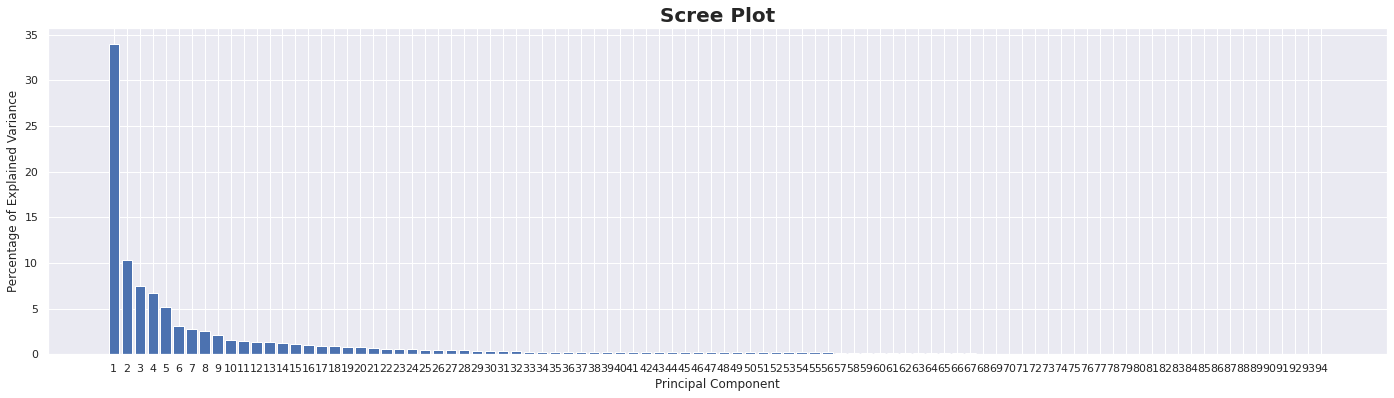

In [ ]:
# Create dataset congifuration with features from upsampling/PCA and upsampling/permutation

# Divide for bankrupt and non-bankrupt sets
df_raw_non_bankrupt = df_scaled_imbalanced[df_raw['Bankrupt?'] == 0]
df_raw_bankrupt = df_scaled_imbalanced[df_raw['Bankrupt?'] == 1]

# Stratify the sets
df_SU_bankrupt = stratify(df_raw_bankrupt)

# Combining the classes
df_SU = pd.concat([df_raw_non_bankrupt, df_SU_bankrupt], ignore_index=True)

(df_X_SU, df_y_SU) = (df_SU.iloc[:, 1:],df_SU.iloc[:, 0])

# PCA on upsampled data
# Applying PCA to data
pca = PCA()
pca.fit(df_X_SU)
df_X_SUPCA = pca.transform(df_X_SU) 

# Scree plot
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(24,6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.title('Scree Plot', fontsize=20, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

var_cutoff = 0.1
n_feat_keep = len(np.where(per_var > var_cutoff)[0])
df_X_SUPCA = df_X_SUPCA[:,:n_feat_keep]
SUPCA_cols = ['PC'+str(n+1) for n in range(n_feat_keep)]
df_X_SUPCA = pd.DataFrame(df_X_SUPCA, columns=SUPCA_cols)

# Permutation
# Splitting train:val:test 60:20:20
X_train, X_test, y_train, y_test = train_test_split(df_SU.iloc[:,1:], df_SU.iloc[:,0], test_size=0.2, random_state=0)   # INPUT THE DESIRED FEATURE SET HERE!
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

# Permutation
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

results = permutation_importance(rfc, X_val, y_val)
importance = results.importances_mean

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

feat_keep = np.where(importance > 0)[0]
df_X_SUP = df_X_SU.iloc[:,feat_keep]

In [318]:
# Another configuration: Uniform/Sort/High Correlation/SMOTE

# Correlation between the features and the labels
feat_label_corr = df_X_EDA_uniform.corrwith(df_y_raw)

# Sort descending
feat_label_corr_sorted = feat_label_corr.abs().sort_values(ascending=False)

# Sorting the features set with descending correlation with the labels
new_col = feat_label_corr_sorted.index
new_col = new_col.to_numpy()
df_X_UNIS = df_X_EDA_uniform.reindex(columns=new_col)

corr_features = correlation(df_X_UNIS, 0.9)
df_X_UNISLC = df_X_UNIS.drop(corr_features, axis=1)

In [320]:
# Config: Uniform/Clean/SMOTE
# Features to drop
feat_to_drop = feat_label_corr_sorted[feat_label_corr_sorted < 0.01].index

# Dropping
df_X_UNICSC = df_X_UNIS.drop(feat_to_drop, axis=1)

corr_features = correlation(df_X_UNICSC, 0.9)
df_X_UNIC = df_X_UNICSC.drop(corr_features, axis=1)

## Comparing performance of dataset configurations

In [349]:
# Apply random forests to a given X-y set and return performance metrics 

def RFC_evaluation(df_X, df_y, random_state=1, n_estimators=100, max_depth=None, class_weight=None, smote=False, final=False):

    # De-upsample df_X and df_y if necessary
    UPSflag = False
    if df_y.shape[0] > df_y_raw.shape[0]:
        UPSflag = True
        df = pd.concat([df_y, df_X], axis=1)
        df.drop_duplicates(inplace=True)
        df_y = df.iloc[:,0]
        df_X = df.iloc[:,1:]
        if df_y.shape[0] > df_y_raw.shape[0]+1:
            print(df_y.shape, df_y_raw.shape)
        assert df_y.shape[0] <= df_y_raw.shape[0]+1

    # Splitting train:val:test 60:20:20
    X_rem, X_test, y_rem, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=random_state, stratify=df_y)   # INPUT THE DESIRED FEATURE SET HERE!
    X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=random_state, stratify=y_rem) # 0.25 x 0.8 = 0.2

    if final:
        (X_train, y_train) = (X_rem, y_rem)
        (X_val, y_val) = (X_test, y_test)

    # Add SMOTE to training set
    if smote:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # smote converts df to nparray, to converting back to df
        #X_train = pd.DataFrame(X_train, columns=df_X.columns)
        #y_train = pd.Series(y_train, name=df_y.name)

    # Re-upsample df_X_train and df_y_train
    elif UPSflag:
        (X_train, y_train) = strat_upsample(X_train, y_train)
        assert X_train.shape[0] == y_train.shape[0]

    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, class_weight=class_weight)
    rfc.fit(X_train, y_train)
    y_hat_val = rfc.predict(X_val)
    cr_val = classification_report(y_val, y_hat_val, output_dict=True)
    bkrpt_acc = cr_val['1']['f1-score']
    macF1 = cr_val['macro avg']['f1-score']
    mr = cr_val['macro avg']['recall']
    acc = cr_val['accuracy']

    #print("Accuracy of Bankrupt Class:",bkrpt_acc)
    #print("Marco F1-Score: ",macF1)
    return {'bkrpt_acc':bkrpt_acc,'macF1':macF1,'acc':acc,'mr':mr}

    #return "\n   "+classification_report(y_val, y_hat_val)

In [361]:
# Datasets dataframe: Add dataset configurations to test here
# Append list: [title, config, X, y]

datasets = []
datasets.append(["Raw Dataset","raw",df_X_raw,df_y_raw])
datasets.append(["Only features with variance = 0 removed","V0",df_X_EDA_var,df_y_raw])
datasets.append(["Features with variance = 0 removed and standardized (z-score)","V0/Std",df_X_EDA_scaled,df_y_raw])
datasets.append(["Features with variance = 0 removed, standardized and sorted with descending correlation with the labels","V0/Std/Srt",df_X_EDA_scaled_sorted,df_y_raw])
datasets.append(["Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed","V0/Std/Srt/SC",df_X_EDA_scaled_sorted_dropped,df_y_raw])
datasets.append(["Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed","V0/Std/Srt/SC/LC = Cln",df_X_manually_clean,df_y_raw])
datasets.append(["SLC","Srt/LC",df_X_SLC,df_y_raw])
datasets.append(["The upsampled standardized set","Std/Up",df_stratified_scaled.iloc[:, 1:],df_stratified_scaled.iloc[:, 0]])
datasets.append(["The upsampled manually cleaned set","Std/Up/Cln",df_stratified_manually_cleaned.iloc[:, 1:],df_stratified_manually_cleaned.iloc[:, 0]])
datasets.append(["SMOTE-ed standardized set","Std/SM",df_X_EDA_scaled,df_y_raw])
datasets.append(["SMOTE-ed manually cleaned set","Std/Cln/SM",df_X_manually_clean,df_y_raw])
datasets.append(["SLCS","Srt/LC/Up",df_X_SLCS,df_y_SLCS])
datasets.append(["Minmax Scaler","Minmax",df_X_EDA_minmax,df_y_raw])
datasets.append(["Max Absolute","Max Absolute",df_X_EDA_maxabs,df_y_raw])
datasets.append(["Robust","Robust",df_X_EDA_robust,df_y_raw])
datasets.append(["Uniform","Uniform",df_X_EDA_uniform,df_y_raw])
datasets.append(["SMOTE Uniform","Uni/SM",df_X_EDA_uniform,df_y_raw])
datasets.append(["SMOTE Uniform, sorted, high correlations removed","Uni/Srt/LC/SM",df_X_UNISLC,df_y_raw])
datasets.append(["SMOTE Uniform, cleaned","Uni/Cln/SM",df_X_UNIC,df_y_raw])
datasets.append(["Gaussian","Gaussian",df_X_EDA_gaussian,df_y_raw])
datasets.append(["Power","Power",df_X_EDA_power,df_y_raw])
datasets.append(["Norm","Norm",df_X_EDA_norm,df_y_raw])
datasets.append(["SMOTE PCA","PCA/SM",df_pca,df_y_raw])
datasets.append(["Upsampling/PCA (>0.1)","Up/PCA",df_X_SUPCA,df_y_SU])
datasets.append(["Upsampling/Permutation (>0)","Up/Perm",df_X_SUP,df_y_SU])
datasets.append(["Raw Dataset","raw",df_X_raw,df_y_raw])
datasets.append(["SMOTE","SM",df_X_raw,df_y_raw])


In [362]:
# Calculate performance metrics for dataset configuration and append metrics
final = True

for ds in datasets:
    smoteFlag = False
    class_weight=None
    title = ds[0]
    if "SMOTE" in title: smoteFlag = True
    if "Class Weight" in title: 
        cws = title[title.index("(")+1:title.index(")")]
        class_weight = {1:int(cws)}
    rfc_eval = RFC_evaluation(ds[2], ds[3], smote=smoteFlag, class_weight=class_weight, final=final)
    ds.extend([rfc_eval['bkrpt_acc'], rfc_eval['macF1'], rfc_eval['acc'], rfc_eval['mr'], rfc_eval['macF1']/ds[2].shape[1], ds[2].shape[1]])

# Create proper dataframe from all data
datasets = pd.DataFrame(datasets, columns=['title','config','X','y','bkrpt_acc','macF1','acc','mac_rec','mF1pf','nFeat'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

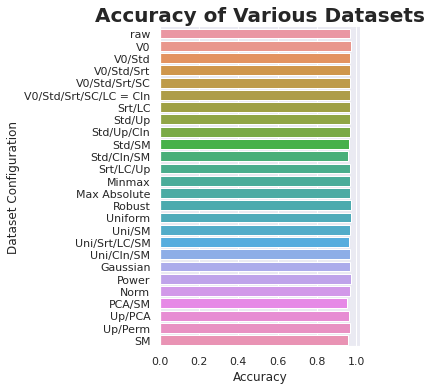

In [352]:
g = sns.catplot(data=datasets, y='config',x='acc', kind='bar', orient='h')
(g.set_axis_labels("Accuracy", "Dataset Configuration"))
plt.title('Accuracy of Various Datasets', fontsize=20, fontweight='bold')
plt.show()

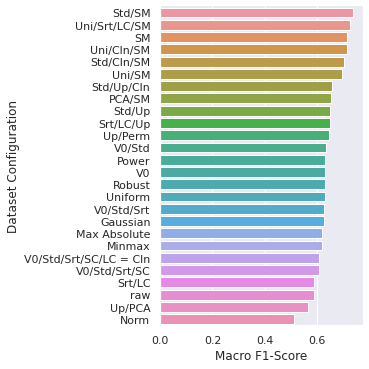

In [365]:
g = sns.catplot(data=datasets.sort_values(by='macF1', ascending=False), y='config',x='macF1', kind='bar', orient='h')
(g.set_axis_labels("Macro F1-Score", "Dataset Configuration"))
#plt.title('Macro F1-Score of Various Datasets', fontsize=20, fontweight='bold')
plt.show()

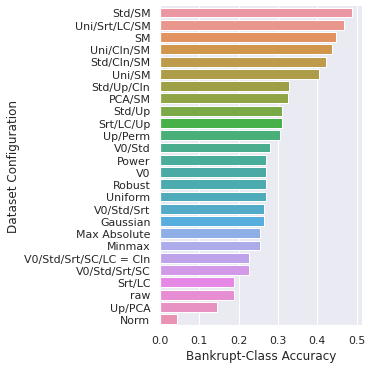

In [364]:
g = sns.catplot(data=datasets.sort_values(by='bkrpt_acc', ascending=False), y='config',x='bkrpt_acc', kind='bar', orient='h')
(g.set_axis_labels("Bankrupt-Class Accuracy", "Dataset Configuration"))
#plt.title('Bankrupt-Class Accuracy of Various Datasets', fontsize=20, fontweight='bold')
#for ds in datasets:
#    g.text(,row.tip, round(row.total_bill,2), color='black', ha="center")

plt.show()

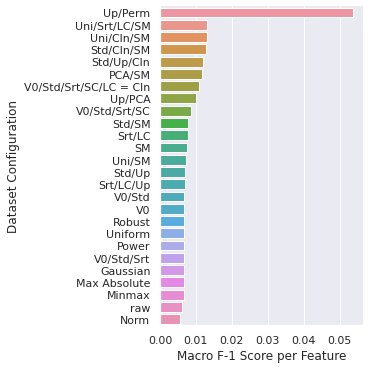

In [370]:
g = sns.catplot(data=datasets.sort_values(by='mF1pf', ascending=False), y='config',x='mF1pf', kind='bar', orient='h')
(g.set_axis_labels("Macro F-1 Score per Feature", "Dataset Configuration"))
#plt.title('Macro F-1 Score per Feature of Various Datasets', fontsize=20, fontweight='bold')
#for ds in datasets:
#    g.text(,row.tip, round(row.total_bill,2), color='black', ha="center")

plt.show()

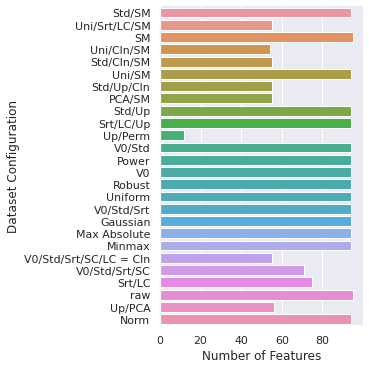

In [368]:
g = sns.catplot(data=datasets.sort_values(by='macF1', ascending=False), y='config',x='nFeat', kind='bar', orient='h')
(g.set_axis_labels("Number of Features", "Dataset Configuration"))
#plt.title('Macro F-1 Score per Feature of Various Datasets', fontsize=20, fontweight='bold')
#for ds in datasets:
#    g.text(,row.tip, round(row.total_bill,2), color='black', ha="center")

plt.show()

In [366]:
datasets.sort_values(by='macF1', ascending=False)

,title,config,X,y,bkrpt_acc,macF1,acc,mac_rec,mF1pf,nFeat
9,SMOTE-ed standardized set,Std/SM,ROA(C) before interest and depreciation...,0 1 1 1 2 1 3 1 4 ...,0.488889,0.735726,0.966276,0.740909,0.007827,94
17,"SMOTE Uniform, sorted, high correlations removed",Uni/Srt/LC/SM,Persistent EPS in the Last Four Seasons...,0 1 1 1 2 1 3 1 4 ...,0.467532,0.726033,0.969941,0.698864,0.013201,55
26,SMOTE,SM,ROA(C) before interest and depreciation...,0 1 1 1 2 1 3 1 4 ...,0.446809,0.713533,0.961877,0.727652,0.007511,95
18,"SMOTE Uniform, cleaned",Uni/Cln/SM,Persistent EPS in the Last Four Seasons...,0 1 1 1 2 1 3 1 4 ...,0.438356,0.711457,0.969941,0.676894,0.013175,54
10,SMOTE-ed manually cleaned set,Std/Cln/SM,Net Income to Total Assets ... Degre...,0 1 1 1 2 1 3 1 4 ...,0.421053,0.700082,0.959677,0.715530,0.012729,55
16,SMOTE Uniform,Uni/SM,ROA(C) before interest and depreciation...,0 1 1 1 2 1 3 1 4 ...,0.405063,0.693660,0.965543,0.674621,0.007379,94
8,The upsampled manually cleaned set,Std/Up/Cln,Net Income to Total Assets ... Degr...,0 0 1 0 2 0 3 0 4 ...,0.327869,0.656248,0.969941,0.610985,0.011932,55
22,SMOTE PCA,PCA/SM,"[[1.73166824799469, 2.1979234947266097, -1.664...",0 1 1 1 2 1 3 1 4 ...,0.326531,0.650718,0.951613,0.667424,0.011831,55
7,The upsampled standardized set,Std/Up,ROA(C) before interest and depreciatio...,0 0 1 0 2 0 3 0 4 ...,0.310345,0.647682,0.970674,0.600379,0.006890,94
11,SLCS,Srt/LC/Up,ROA(C) before interest and depreciatio...,0 0 1 0 2 0 3 0 4 ...,0.310345,0.647682,0.970674,0.600379,0.006890,94
